# Import libraries

In [19]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import resample
from sklearn.datasets import load_iris, load_diabetes

In [20]:
iris = load_iris()
features = iris.data
target = iris.target
iris_df = pd.DataFrame(data=features, columns=iris.feature_names)
iris_df['target'] = target
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


## First look at our dataset

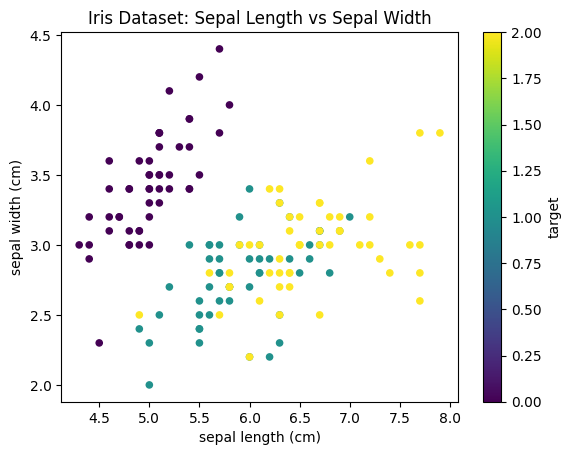

In [21]:
import matplotlib.pyplot as plt

iris_df.plot(kind='scatter', x='sepal length (cm)', y='sepal width (cm)', c='target', colormap='viridis')
plt.title('Iris Dataset: Sepal Length vs Sepal Width')
plt.show()

# Bootstrapping

In [22]:
# Function for Bootstrapping in Linear Regression
def bootstrap_linear_regression(data, n_bootstrap=1000):
    n_size = int(len(data) * 0.50) # define our train / test split
    values = data.values
    stats = []

    for i in range(n_bootstrap):

        train = resample(values, n_samples=n_size) # sample our train set
        test = np.array([x for x in values if x.tolist() not in train.tolist()]) # create our out-of-bag set / test set

        # Train model on resampled data
        model = DecisionTreeClassifier()
        model.fit(train[:, :-1], train[:, -1])

        # Predict for the original data
        predictions = model.predict(test[:, :-1])
        acs = accuracy_score(test[:, -1], predictions)
        stats.append(acs)

    return stats

## Run the Bootstrapping and plot the result

Confidence interval: 88.6 to 97.8


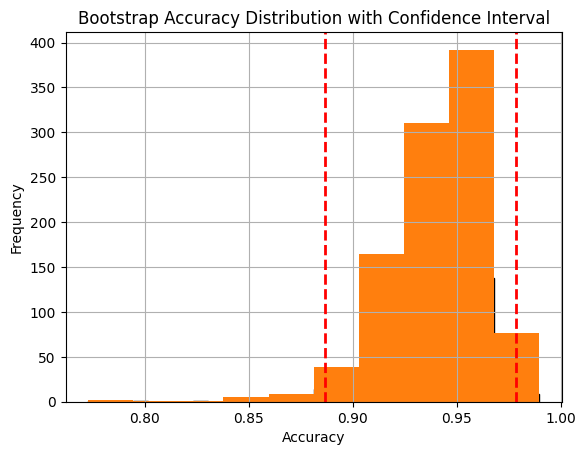

In [23]:
stats = bootstrap_linear_regression(data=iris_df)

# Calculate the confidence interval
alpha = 0.95
p = ((1.0 - alpha) / 2.0) * 100
lower = max(0.0, np.percentile(stats, p))
p = (alpha + ((1.0 - alpha) / 2.0)) * 100
upper = min(1.0, np.percentile(stats, p))
print(f'Confidence interval: {lower*100:.1f} to {upper*100:.1f}')
# Draw the confidence interval
plt.axvline(lower, color='r', linestyle='dashed', linewidth=2)
plt.axvline(upper, color='r', linestyle='dashed', linewidth=2)
plt.title('Bootstrap Accuracy Distribution with Confidence Interval')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.hist(stats, bins=30, edgecolor='black')
plt.hist(stats)
plt.grid()
plt.show()

# Jackknife

## Different dataset

In [24]:
# Load the diabetes dataset
diabetes = load_diabetes()
diabetes_features = diabetes.data
diabetes_target = diabetes.target
diabetes_df = pd.DataFrame(data=diabetes_features, columns=diabetes.feature_names)
diabetes_df['target'] = diabetes_target
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


## Plot this data

/Users/niclasflehmig/VisualCodeProjects/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1345: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


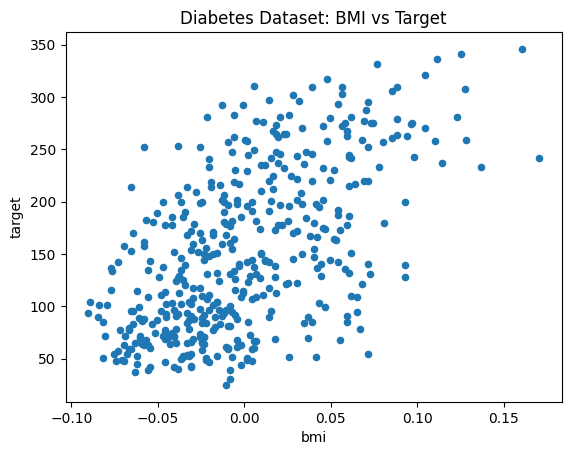

In [25]:
# Plot the diabetes data but only for one feature
diabetes_df.plot(kind='scatter', x='bmi', y='target', colormap='viridis')
plt.title('Diabetes Dataset: BMI vs Target')
plt.show()

## Jackknife code

In [26]:
# Function to correct bias using Jackknife resampling
def jackknife_bias_correction(x, y):
    n = len(x)
    jackknife_estimates = np.zeros(n)
    model = LinearRegression()

    for i in range(n):
        # Leave one observation out
        x_train = np.delete(x, i, axis=0)
        y_train = np.delete(y, i, axis=0)

        # Train the model
        model.fit(x_train, y_train)

        # Store the coefficient estimate for the left-out observation
        jackknife_estimates[i] = model.coef_[0]

    # Calculate the Jackknife estimate of the coefficient
    jackknife_estimate = np.mean(jackknife_estimates)

    # Calculate the bias
    original_model = LinearRegression().fit(x, y)
    original_estimate = original_model.coef_[0]
    bias = (n - 1) * (jackknife_estimate - original_estimate)

    # Correct the bias
    bias_corrected_estimate = original_estimate - bias

    return original_estimate, bias_corrected_estimate, bias

## Return the original estimate and the correction

In [43]:
# Apply the Jackknife bias correction
original_estimate, bias_corrected_estimate, bias = jackknife_bias_correction(diabetes_features, diabetes_target)
print(f'Original Estimate: {original_estimate}, Bias Corrected Estimate: {bias_corrected_estimate}, Bias: {bias}')

Original Estimate: -10.009866299810458, Bias Corrected Estimate: -9.673981614010156, Bias: -0.33588468580030195
